In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from scipy.ndimage import gaussian_filter, median_filter, binary_opening, binary_closing
from scipy.ndimage import binary_dilation, generate_binary_structure
import sys
import tifffile as tf
import torch

sys.path.append("../")
from data_prep import collect, load, draw, save
from data_prep.image import Image
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
from scipy.ndimage import zoom

scale_file = "/home/brysongray/data/scaling_gold.csv"
scale_df = pd.read_csv(scale_file)

swc_dir = "/home/brysongray/data/gold166/"
swc_paths = [f for x in os.walk(swc_dir) for f in glob(os.path.join(x[0], "*.swc")) if "ano" not in f and "stamp" not in f]
swc_out = "/home/brysongray/data/gold166_swc_scaled"

# get tif images
img_dir = "/home/brysongray/data/gold166_tifs"
img_files = os.listdir(img_dir)
img_out = "/home/brysongray/data/gold166_tifs_scaled"
for f in img_files:
    if os.path.exists(os.path.join(img_out, f.split("/")[-1])):
        continue
    # get scale info for img
    img_fname = f.split(".")[0]
    row = [i for i,swc_file in enumerate(scale_df["swc_file"].tolist()) if img_fname == swc_file.split('00_sorted_')[-1].split('.')[0]]
    try:
        row = row[0]
    except IndexError:
        print(f"SWC file with matching name {img_fname} not found.")
        continue
    xy, z = scale_df.iloc[row]["x_y_pix_size":"z_pix_size"]

    # load image
    img = tf.imread(os.path.join(img_dir,f))

    # Check if resampling is needed
    swc_path = [x for x in swc_paths if img_fname == x.split('/')[-1].split('.')[0]]
    try:
        swc_path = swc_path[0]
    except IndexError:
        continue
    swc_list = load.swc(swc_path)
    if xy != z:
        # Calculate the scaling factor for z dimension
        scale_factor = z / xy
        
        # Resize along z axis to make isotropic
        scale_factors = (scale_factor, 1, 1)  # Only scale z dimension
        img = zoom(img, scale_factors, order=1)
        
        new_list = []
        for x in swc_list:
            x[4] = x[4]*scale_factor
            new_list.append(x)
        print(f"Resampled image from shape {img.shape} to make isotropic pixels (xy={xy}, z={z})")
    else:
        print(f"Image already has isotropic pixels (xy={xy}, z={z})")
        new_list = swc_list
    tf.imwrite(os.path.join(img_out, f.split("/")[-1]), img)
    save.write_swc(new_list, os.path.join(swc_out, swc_path.split('/')[-1]))

loading file: /home/brysongray/data/gold166/p_checked6_mouse_RGC_uw/ho_140921c3/140921c3.tif.v3dpbd.swc
Resampled image from shape (108, 800, 800) to make isotropic pixels (xy=0.1, z=0.3)
loading file: /home/brysongray/data/gold166/p_checked6_mouse_RGC_uw/ho_091204c2/091204c2.tif.v3dpbd.swc
Resampled image from shape (405, 2048, 2048) to make isotropic pixels (xy=0.1, z=0.3)
loading file: /home/brysongray/data/gold166/p_checked7_janelia_flylight_part1/GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_4_G2-right_optic_lobe.v3draw.extract_1/GMR_57C10_AD_01-Two_recombinase_flipouts_A-f-A-20111108_4_G2-right_optic_lobe.v3draw.extract_1.v3dpbd.swc
Image already has isotropic pixels (xy=0.38, z=0.38)
loading file: /home/brysongray/data/gold166/p_checked6_mouse_RGC_uw/SV_140918c7/140918c7.tif.v3dpbd.swc
Resampled image from shape (115, 1600, 1600) to make isotropic pixels (xy=0.33, z=1.0)
loading file: /home/brysongray/data/gold166/p_checked7_janelia_flylight_part1/GMR_57C10_AD_01-Two_r

In [8]:
for f in img_files:
    img_fname = f.split(".")[0]
    swc_path = [x for x in swc_paths if img_fname == x.split('/')[-1].split('.')[0]]
    if len(swc_path) == 0:
        print(f"No matching file for image file: {img_fname}")

No matching file for image file: m16_cing_1_9_cropped_neurona
No matching file for image file: uint8_ChaMARCM-F000143_seg001
No matching file for image file: Cell1_40x_1
No matching file for image file: Image7
No matching file for image file: uint8_ChaMARCM-F000006_seg001
No matching file for image file: uint8_ChaMARCM-F000127_seg001
No matching file for image file: Image10
No matching file for image file: case1-slide2-section2-left-cell3_merge_c2
No matching file for image file: uint8_ChaMARCM-F000087_seg001
No matching file for image file: Image5
No matching file for image file: 1_a_Ch2


In [17]:
swc_files = [f for x in os.walk(swc_dir) for f in glob(os.path.join(x[0], "*.swc"))]
swc_files = sorted(swc_files)
for i,f in enumerate(swc_files):
    print(i,f) 
            

0 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.ano_stamp_2015_06_15_15_16.swc_sorted.swc
1 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc
2 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_10-2900-control-cell-05.oif-C0/10-2900-control-cell-05.oif-C0.v3dpbd.ano_stamp_2015_06_15_15_47.swc_sorted.swc
3 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_10-2900-control-cell-05.oif-C0/10-2900-control-cell-05.oif-C0.v3dpbd.swc
4 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_10-2909-s5-left-cell3_merge_c2/10-2909-s5-left-cell3_merge_c2.v3dpbd.swc
5 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_10-2909-s5-left-cell3_merge_c2/10-2909-s5-left-cell3_merge_c2.v3dpbd_stamp_2015_06_15_17_50.swc_sorted.swc
6 /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-sectio

In [18]:
missing_files = [
    "/home/brysongray/data/gold166/p_checked6_fruitfly_larvae_gmu/done_2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024.czi_C_1/2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024.czi_C_1.tif.v3dpbd.ano_stamp_2015_06_15_16_23.swc",
    "/home/brysongray/data/gold166/p_checked6_fruitfly_larvae_gmu/done_Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red/Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red.tif.v3dpbd.ano_stamp_2015_06_17_10_44.swc",
    "/home/brysongray/data/gold166/p_checked6_fruitfly_larvae_gmu/done_Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaE_F-actinGFP_MT-Red/Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaE_F-actinGFP_MT-Red.tif.v3dpbd.ano_stamp_2015_06_15_17_11.swc",
    "/home/brysongray/data/gold166/p_checked6_human_allen_confocal/m16_cing_1_9_cropped/m16_cing_1_9_cropped_neurona.v3dpbd.ano_stamp_2015_06_16_16_29.swc",
    "/home/brysongray/data/gold166/p_checked7_taiwan_flycirciut/uint8_ChaMARCM-F000143_seg001.lsm_c_3.tif/uint8_ChaMARCM-F000143_seg001.lsm_c_3.tif.v3dpbd.ano_stamp_2015_06_13_11_33.swc",
    "/home/brysongray/data/gold166/p_checked6_human_allen_confocal/in_house1/Cell1_40x_1.0umstep_H15.06.005.07.02_cell1.oif.files.v3dpbd.ano_stamp_2015_06_13_15_35.swc",
    "/home/brysongray/data/gold166/p_checked6_human_culturedcell_Cambridge_in_vitro_confocal_GFP/Image7/Image7.v3dpbd.ano_stamp_2015_06_13_15_48.swc",
    "/home/brysongray/data/gold166/p_checked7_taiwan_flycirciut/uint8_ChaMARCM-F000006_seg001.lsm_c_3.tif/uint8_ChaMARCM-F000006_seg001.lsm_c_3.tif.v3dpbd.ano_stamp_2015_06_12_23_53.swc",
    "/home/brysongray/data/gold166/p_checked7_taiwan_flycirciut/uint8_ChaMARCM-F000127_seg001.lsm_c_3.tif/uint8_ChaMARCM-F000127_seg001.lsm_c_3.tif.v3dpbd.ano_stamp_2015_06_13_10_33.swc",
    "/home/brysongray/data/gold166/p_checked6_human_culturedcell_Cambridge_in_vitro_confocal_GFP/Image10/Image10.v3dpbd_stamp_2015_06_15_17_26.swc",
    "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section2-left-cell3_merge_c2_retimestampledforfilenamingconvention/case1-slide2-section2-left-cell3_merge_c2.v3dpbd.ano_stamp_2015_07_15_12_48.swc",
    "/home/brysongray/data/gold166/p_checked7_taiwan_flycirciut/uint8_ChaMARCM-F000087_seg001.lsm_c_3.tif_checked7indicatednoeditingneeded_retimestampedforconsistentdataformat/uint8_ChaMARCM-F000087_seg001.lsm_c_3.tif.v3dpbd.ano_stamp_2015_07_14_12_02.swc",
    "/home/brysongray/data/gold166/p_checked6_human_culturedcell_Cambridge_in_vitro_confocal_GFP/Image5/Image5.v3dpbd.ano_stamp_2015_06_13_15_46.swc",
    "/home/brysongray/data/gold166/p_checked6_zebrafish_horizontal_cells_UW/1_a_Ch2/1_a_Ch2.tif_uint8.v3dpbd.ano_stamp_2015_06_13_16_02.swc"

]

## Resample and copy missing files

In [25]:
file_key = {"2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024": "2_CL-III_X_Myr-GFP_v_pda_MT-mCherry_membrane-GFP_A_1024",
            "Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red":"Result_of_C1-CL-I_X-Mas__x_OregonR_ddaD_F-actinGFP_MT-Red",
            "Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaE_F-actinGFP_MT-Red":"Result_of_C1-CL-I_X-Mas__x_OregonR_ddaE_F-actinGFP_MT-Red"}

for f in missing_files:
    # get tif file that matches
    img_fname = f.split('/')[-1].split('.')[0]
    img_path = os.path.join(img_dir, img_fname+'.tif')
    if os.path.exists(img_path):
        print(f"Found image file: {img_path}")
    else:
        raise FileNotFoundError(f"File {img_path} not found.")

    # get scale info for img
    if img_fname in file_key.keys():
        img_fname = file_key[img_fname]
    row = [i for i,swc_file in enumerate(scale_df["swc_file"].tolist()) if img_fname in swc_file.split('00_sorted_')[-1]]
    try:
        row = row[0]
    except IndexError:
        print(f"SWC file with matching name {img_fname} not found.")
        continue
    xy, z = scale_df.iloc[row]["x_y_pix_size":"z_pix_size"]

    # load image
    img = tf.imread(img_path)

    # Check if resampling is needed
    swc_list = load.swc(f)
    if xy != z:
        # Calculate the scaling factor for z dimension
        scale_factor = z / xy
        
        # Resize along z axis to make isotropic
        scale_factors = (scale_factor, 1, 1)  # Only scale z dimension
        img = zoom(img, scale_factors, order=1)
        
        new_list = []
        for x in swc_list:
            x[4] = x[4]*scale_factor
            new_list.append(x)
        print(f"Resampled image from shape {img.shape} to make isotropic pixels (xy={xy}, z={z})")
    else:
        print(f"Image already has isotropic pixels (xy={xy}, z={z})")
        new_list = swc_list
    tf.imwrite(os.path.join(img_out, img_path.split("/")[-1]), img)
    save.write_swc(new_list, os.path.join(swc_out, f.split('/')[-1]))

Found image file: /home/brysongray/data/gold166_tifs/2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024.tif
loading file: /home/brysongray/data/gold166/p_checked6_fruitfly_larvae_gmu/done_2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024.czi_C_1/2_CL-III_X_Myr-GFP_v'pda_MT-mCherry_membrane-GFP_A_1024.czi_C_1.tif.v3dpbd.ano_stamp_2015_06_15_16_23.swc
Resampled image from shape (73, 1024, 1024) to make isotropic pixels (xy=0.593, z=1.5)
Found image file: /home/brysongray/data/gold166_tifs/Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red.tif
loading file: /home/brysongray/data/gold166/p_checked6_fruitfly_larvae_gmu/done_Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red/Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaD_F-actinGFP_MT-Red.tif.v3dpbd.ano_stamp_2015_06_17_10_44.swc
Resampled image from shape (23, 524, 1023) to make isotropic pixels (xy=0.593, z=1.5)
Found image file: /home/brysongray/data/gold166_tifs/Result_of_C1-CL-I(X-Mas)_x_OregonR_ddaE_F-actinGFP_MT-Red.

## Filter out files that don't have the correct radii

In [ ]:
swc_dir = "/home/brysongray/data/gold166_swc_scaled"
swc_files = os.listdir(swc_dir)

to_remove = {}
for i in range(len(swc_files)):
    swc_file = swc_files[i]
    # load and parse the SWC file data
    swc_list = load.swc(os.path.join(swc_dir, swc_file))
    sections, sections_graph = load.parse_swc(swc_list)
    segments = []
    for section in sections.values():
        segments.append(section)
    segments = np.concatenate(segments)
    if segments.max(axis=(0,1))[3] <= 1.0:
        to_remove[i] = swc_file

loading file: /home/brysongray/data/gold166_swc_scaled/Cell1_40x_1.0umstep_H15.06.005.07.02_cell1.oif.files.v3dpbd.ano_stamp_2015_06_13_15_35.swc
loading file: /home/brysongray/data/gold166_swc_scaled/140921c16.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/Image31.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_E2-right_optic_lobe.v3draw.extract_3.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A1-right_optic_lobe.v3draw.extract_5.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/0661_seg.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/neuron4.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_s

In [35]:
to_remove

{2: '1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc',
 9: '6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif_uint8.v3dpbd.swc',
 13: '1_2_Ch2.tif_uint8.v3dpbd.swc',
 17: '1_1_Live_2-2-2010_9-52-24_AM_med_Red.tif_uint8.v3dpbd.swc',
 48: 'slice12_4to51_ch2.tif.v3dpbd.neuron1.swc',
 65: '1_10_Ch2.tif_uint8.v3dpbd.swc',
 81: '120111_05new_ch2.tif.v3dpbd.neuron1.swc',
 94: '10-2909-s5-left-cell3_merge_c2.v3dpbd.swc',
 107: '1_a_Ch2.tif_uint8.v3dpbd.ano_stamp_2015_06_13_16_02.swc',
 115: 'case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc',
 118: '10-2912-s1-cell1_merge_c2.v3dpbd.swc',
 126: '10_3dpf_Live_1-28-2010_5-20-37_PM_med_Red.tif_uint8.v3dpbd.swc',
 144: '1_9_Ch2.tif_uint8.v3dpbd.swc',
 147: '12_3dpf_Live_1-28-2010_5-47-24_PM_med_Red.tif_uint8.v3dpbd.swc'}

## Check for any files with segments that lie outside the image

In [38]:
img_dir = "/home/brysongray/data/gold166_tifs_scaled/"
swc_dir = "/home/brysongray/data/gold166_swc_scaled/"

for i, swc_file in enumerate(os.listdir(swc_dir)):
    img_file = [f for f in os.listdir(img_dir) if f.split('.')[0] == swc_file.split('.')[0]]
    if len(img_file) != 1:
        raise Exception(f"{len(img_file)} files match SWC file name: {swc_file.split('.')[0]}")
    img_file = img_file[0]
    img = tf.imread(os.path.join(img_dir,img_file))
    shape = img.shape

    swc_list = load.swc(os.path.join(swc_dir, swc_file))
    sections, graph = load.parse_swc(swc_list)

    segments = []
    for section in sections.values():
        segments.append(section)
    segments = np.concatenate(segments)

    max_coords = segments.max(axis=(0,1))[:3]
    min_coords = segments.min(axis=(0,1))[:3]

    # Check if any points are outside the image boundaries
    out_of_bounds = False
    if any(max_coords[i] >= shape[i] for i in range(3)) or any(min_coords[i] < 0 for i in range(3)):
        out_of_bounds = True
        print(f"Out of bounds segments in {swc_file}:")
        print(f"  Image shape: {shape}")
        print(f"  Min coords: {min_coords}")
        print(f"  Max coords: {max_coords}")

        if out_of_bounds:
            to_remove[i] = swc_file


        # # Create a directory for problematic files if it doesn't exist
        # swc_out_of_bounds_dir = os.path.join(os.path.dirname(swc_dir), "gold166_swc_scaled_out_of_bounds")
        # if not os.path.exists(swc_out_of_bounds_dir):
        #     os.makedirs(swc_out_of_bounds_dir)
        
        # # Move the file to the out_of_bounds directory
        # shutil.move(os.path.join(swc_dir, swc_file), os.path.join(swc_out_of_bounds_dir, swc_file))
    



loading file: /home/brysongray/data/gold166_swc_scaled/Cell1_40x_1.0umstep_H15.06.005.07.02_cell1.oif.files.v3dpbd.ano_stamp_2015_06_13_15_35.swc
loading file: /home/brysongray/data/gold166_swc_scaled/140921c16.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/Image31.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-m-A02-20111101_2_E2-right_optic_lobe.v3draw.extract_3.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/GMR_57C10_AD_01-1xLwt_attp40_4stop1-f-A01-20110325_3_A1-right_optic_lobe.v3draw.extract_5.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/0661_seg.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc
loading file: /home/brysongray/data/gold166_swc_scaled/neuron4.v3dpbd.swc
Out of bounds segments in neuron4.v3dpbd.swc:
  I

## Move files to directory of problematic files

In [39]:
import os
import shutil

# Define the destination directory
swc_removed_dir = "/home/brysongray/data/gold166_swc_scaled_removed"

# Create the destination directory if it doesn't exist
if not os.path.exists(swc_removed_dir):
    os.makedirs(swc_removed_dir)

# Get the list of files to remove from the to_remove dictionary
files_to_remove = list(to_remove.values())

# Loop through each file in files_to_remove
moved_count = 0
for file_name in files_to_remove:
    source_path = os.path.join(swc_dir, file_name)
    dest_path = os.path.join(swc_removed_dir, file_name)
    
    # Check if the file exists in swc_dir
    if os.path.exists(source_path):
        # Move the file to swc_removed_dir
        shutil.move(source_path, dest_path)
        moved_count += 1
        print(f"Moved: {file_name}")
    else:
        print(f"File not found: {file_name}")

print(f"Total files moved: {moved_count} out of {len(files_to_remove)}")

Moved: 1201_01_s06b_L36_Sum_ch2.tif.v3dpbd.swc
Moved: 6_1_Live_2-2-2010_11-05-38_AM_med_Red.tif_uint8.v3dpbd.swc
Moved: 1_2_Ch2.tif_uint8.v3dpbd.swc
Moved: 1_1_Live_2-2-2010_9-52-24_AM_med_Red.tif_uint8.v3dpbd.swc
Moved: slice12_4to51_ch2.tif.v3dpbd.neuron1.swc
Moved: 1_10_Ch2.tif_uint8.v3dpbd.swc
Moved: 120111_05new_ch2.tif.v3dpbd.neuron1.swc
Moved: 10-2909-s5-left-cell3_merge_c2.v3dpbd.swc
Moved: 1_a_Ch2.tif_uint8.v3dpbd.ano_stamp_2015_06_13_16_02.swc
Moved: case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc
Moved: 10-2912-s1-cell1_merge_c2.v3dpbd.swc
Moved: 10_3dpf_Live_1-28-2010_5-20-37_PM_med_Red.tif_uint8.v3dpbd.swc
Moved: 1_9_Ch2.tif_uint8.v3dpbd.swc
Moved: 12_3dpf_Live_1-28-2010_5-47-24_PM_med_Red.tif_uint8.v3dpbd.swc
Moved: neuron4.v3dpbd.swc
Moved: neuron2.v3dpbd.swc
Moved: 3_CL-IV_x_Ank2-IR_ddaC_membrane-B.tif.v3dpbd.swc
Moved: case1-slide2-section2-left-cell3_merge_c2.v3dpbd.ano_stamp_2015_07_15_12_48.swc
Moved: 140921c22.tif.v3dpbd.swc
Total files moved: 19 out of 19


In [48]:
img_dir = "/home/brysongray/data/gold166_tifs_scaled/"
swc_dir = "/home/brysongray/data/gold166_swc_scaled/"

# i=34
i=1
img_files = os.listdir(img_dir)
img_file = img_files[i]
img = tf.imread(os.path.join(img_dir,img_file))

swc_files = os.listdir(swc_dir)
swc_file = [f for f in swc_files if img_file.split('.')[0] == f.split('.')[0]]
try:
    swc_file = swc_file[0]
except IndexError:
    print(f"Could not find matching SWC file for image file: {img_file.split('.')[0]}")
swc_list = load.swc(os.path.join(swc_dir, swc_file))

sections, section_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)
segments = []
for section in sections.values():
    segments.append(section)
segments = np.concatenate(segments)

density = draw.draw_neuron_density(segments, img.shape)
mask = draw.draw_neuron_mask(density, threshold=5.0)

branch_mask = Image(torch.zeros_like(mask))
for point in branches:
    branch_mask.draw_point(point[:3], radius=point[3].item(), binary=True, value=1, channel=0)

loading file: /home/brysongray/data/gold166_swc_scaled/091204c2.tif.v3dpbd.swc


## View skeleton with branches using radius info

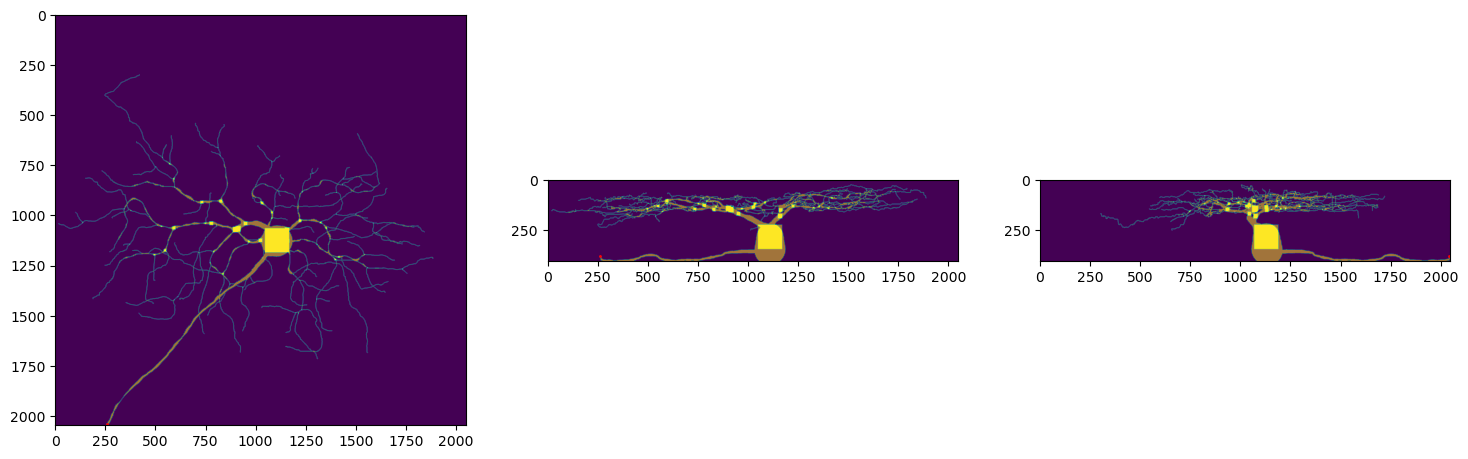

In [49]:
fig, ax = plt.subplots(1,3, figsize=(18,18))
root_node = min(sections.keys())
ax[0].scatter(y=sections[root_node][0,0,1],x=sections[root_node][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0))
ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.5)
ax[1].scatter(y=sections[root_node][0,0,0],x=sections[root_node][0,0,2], c='r', s=1)
ax[1].imshow(mask[0].amax(1))
ax[1].imshow(branch_mask.data[0].amax(1), alpha=0.5)
ax[2].scatter(y=sections[root_node][0,0,0],x=sections[root_node][0,0,1], c='r', s=1)
ax[2].imshow(mask[0].amax(2))
ax[2].imshow(branch_mask.data[0].amax(2), alpha=0.5)

## View neuron with skeleton

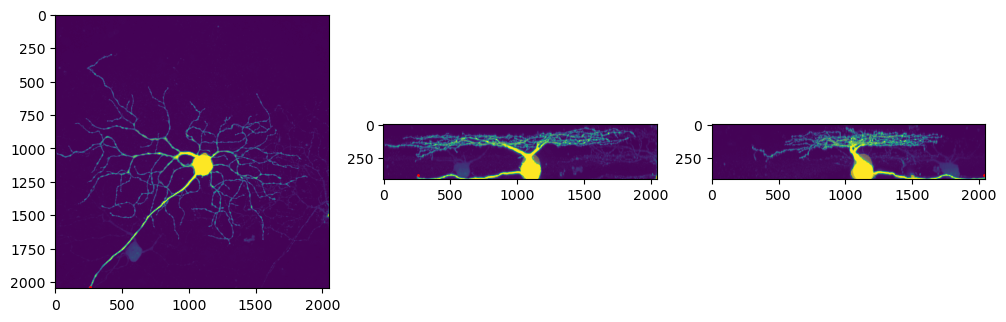

In [50]:
density = draw.draw_neuron_density(segments[:,:3], img.shape, width=3)
mask = draw.draw_neuron_mask(density, threshold=5.0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[0].scatter(y=sections[root_node][0,0,1],x=sections[root_node][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0), alpha=0.3)
# ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.4)
ax[1].imshow(img.max(1))
ax[1].imshow(mask[0].amax(1), alpha=0.3)
ax[1].scatter(y=sections[root_node][0,0,0],x=sections[root_node][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(mask[0].amax(2), alpha=0.3)
ax[2].scatter(y=sections[root_node][0,0,0],x=sections[root_node][0,0,1], c='r', s=1)

## View skeleton with branches

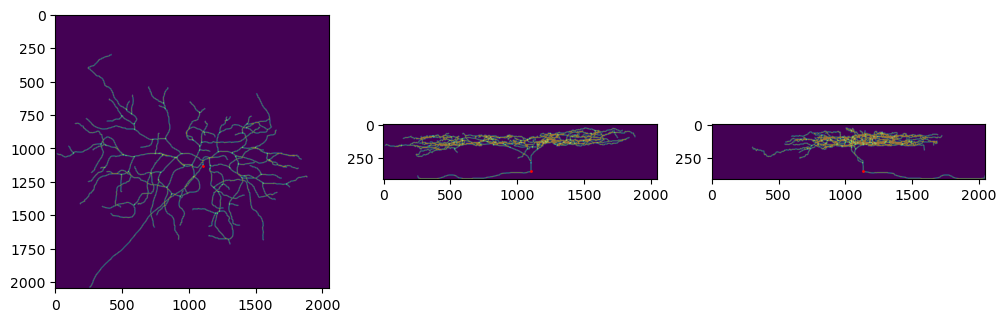

In [43]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0))
ax[0].imshow(branch_mask.data[0].amax(0), alpha=0.5)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[1].imshow(mask[0].amax(1))
ax[1].imshow(branch_mask.data[0].amax(1), alpha=0.5)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)
ax[2].imshow(mask[0].amax(2))
ax[2].imshow(branch_mask.data[0].amax(2), alpha=0.5)


## View neuron with skeleton using radius info

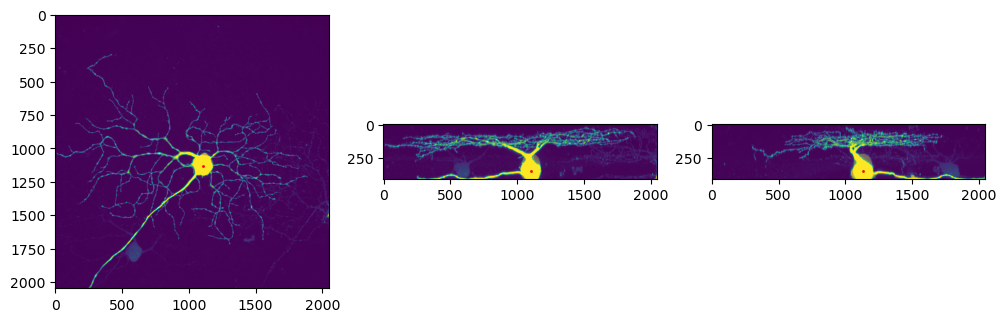

In [ ]:
density = draw.draw_neuron_density(segments, img.shape, width=3)
mask = draw.draw_neuron_mask(density, threshold=5.0)

branch_mask = Image(torch.zeros_like(mask))
for point in branches:
    branch_mask.draw_point(point[:3], radius=point[3].item(), binary=True, value=1, channel=0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0), aspect="auto")
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[0].imshow(mask[0].amax(0), alpha=0.3)
ax[1].imshow(img.max(1))
ax[1].imshow(mask[0].amax(1), alpha=0.3)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(mask[0].amax(2), alpha=0.3)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)

## Segment soma by filtering the mask for segments with a large radius

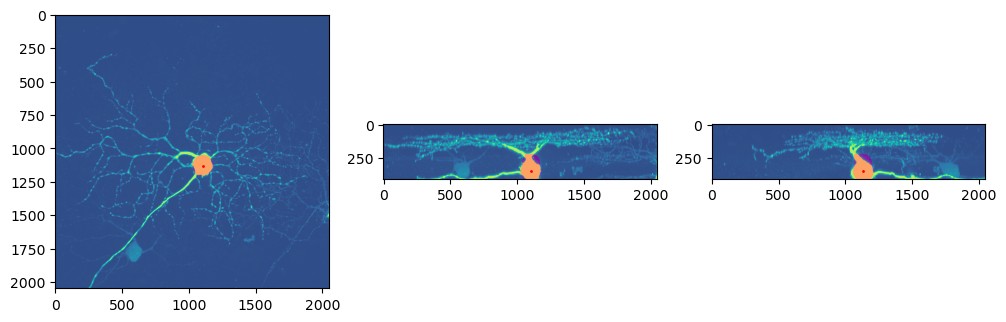

In [36]:
large_segments_coords = np.argwhere(segments[:,:,3] >= 20.0)
large_segments = segments[large_segments_coords[0]]
density = draw.draw_neuron_density(large_segments, img.shape, width=3)
large_segments_mask = draw.draw_neuron_mask(density, threshold=5.0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[0].imshow(large_segments_mask[0].amax(0), cmap='cool', alpha=0.3)
ax[0].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r', s=1)
ax[1].imshow(img.max(1))
ax[1].imshow(large_segments_mask[0].amax(1), cmap='cool', alpha=0.3)
ax[1].scatter(y=sections[1][0,0,0],x=sections[1][0,0,2], c='r', s=1)
ax[2].imshow(img.max(2))
ax[2].imshow(large_segments_mask[0].amax(2), cmap='cool', alpha=0.3)
ax[2].scatter(y=sections[1][0,0,0],x=sections[1][0,0,1], c='r', s=1)